In [24]:
import os
from typing import Tuple, List, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

# sklearn
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Keras (Torch) as backend
os.environ["KERAS_BACKEND"] = "torch"   # IF NOT SPECIFIED, TensorFlow will be used as BACKEND
import keras
from keras.optimizers import SGD

# Logistic regression using Keras & PyTorch
* <font color="teal"><b>author: Wim R.M. Cardoen</b></font>
* <font color="teal"><b>e-mail: wcardoen [\at] gmail.com</b></font>

* For <font color="green"><b>more advanced networks</b></font> most AI/deep learing practitioners:
  - neither derive the underlying equations.
  - nor implement these equations from scratch.
* Implementing <font color="green"><b>highly performant code</b></font>
  for the general case is significantly more <font color="green"><b>demanding and time-consuming</b></font>.<br>It requires:
  - mastery of a <font color="red"><b>compiled language</b></font> (e.g., `C++`)
  - understanding of <font color="red"><b>parallel computing</b></font> (multi-node, multi-GPU setups).
  - a solid foundation in <font color="red"><b>algorithms and numerical analysis</b></font>.
* To address these kind of challenges, humanity adopted over time a
  <a href="https://www.marxists.org/reference/archive/smith-adam/works/wealth-of-nations/book01/ch01.htm"><b>division of labour</b></a>.   
* Instead of building everything from scratch, practitioners rely on <font color="green"><b>frameworks</b></font>.<br>The most commonly used frameworks are currently:
  - <a href="https://pytorch.org/"><b>PyTorch</b></a>
  - <a href="https://www.tensorflow.org/"><b>TensorFlow</b></a>
  - <a href="https://docs.jax.dev/en/latest/"><b>Jax</b></a>
  - <a href="https://keras.io/"><b>Keras</b></a>
  
Our goal is to implement the logistic regression model (<a href="./lecture1.ipynb"><b>Lecture 1</b></a>) using Keras & PyTorch.

We will proceed in two different ways:
1. by using <font color="green"><b>Keras</b></font> (PyTorch as backend) : more user-friendly 
2. by using <font color="green"><b>PyTorch</b></font> as such: low-level but versatile.

In <a href="./lecture2.ipynb"><b>Lecture 2</b></a> we will use Keras but will also provide its lower level counter part (as addendum).

In [25]:
# Generate a data set
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
print(f"Generate the data set ...")
print(f"  X.shape:{X.shape}")
print(f"  y.shape:{y.shape}")

# Split the data in training and a test set.
test_ratio = 0.30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=42)
print(f"Splitting the data set (splitting ratio:{test_ratio})")
print(f"  Training Data Set:")
print(f"    X_train.shape : {X_train.shape}")
print(f"    y_train.shape : {y_train.shape}")
print(f"  Test Data Set:")
print(f"    X_test.shape  : {X_test.shape}")
print(f"    y_test.shape  : {y_test.shape}")

Generate the data set ...
  X.shape:(500, 2)
  y.shape:(500,)
Splitting the data set (splitting ratio:0.3)
  Training Data Set:
    X_train.shape : (350, 2)
    y_train.shape : (350,)
  Test Data Set:
    X_test.shape  : (150, 2)
    y_test.shape  : (150,)


# 1.Keras (with PyTorch backend)
Phases:<br>
- A. set up the model: specify the layers and units
- B. `compile` the model: specify the optimizer, loss, metrics
- C. `fit` the model: training
- D. `evaluate` the model: testing
- E. `predict`: use the model to predict outcomes for input samples

### A.Set up the model
consists mainly of:
- providing the layout of the neural net (layers and #units/layer)
- specifying the activation functions for each layer
  
`Sequential class`: groups a linear stack of layers into a Model (For more info on the API, see <a href="https://keras.io/api/models/sequential/"><b>here</b></a>)

In [3]:
# Setting up the model
model1 =  keras.Sequential([
                keras.layers.Input(shape=(2,)),                      # Input layer: input vector (2 features)
                keras.layers.Dense(units=1, activation='sigmoid')],  # Output layer: 1 Class
                name="LogisticRegression")       
print(model1.summary())

# Info on kernel_regularization, etc.
print(f"Info on the layers ...")
for layer in model1.layers:
    print(f"  Layer:'{layer.name}'")
    print(layer.get_config())

Model: "LogisticRegression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

None
Info on the layers ...
  Layer:'dense'
{'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


### B.Compile the model

The `compile` method's task it to provide the model with:
- an <font color="teal"><b>optimization method/optimizer</b></font> (e.g. `SGD`, `RMSprop`,`Adam`, `AdamW`, $\ldots$)<br>
  (For more info on the optimizers, see <a href="https://keras.io/api/optimizers/"><b>here</b></a>)
- a <font color="teal"><b>loss</b></font> function (e.g. `binary_crossentropy`, `categorical_crossentropy`, `mean_squared_error` , $\ldots$)<br>
  (For more info on the loss function, see <a href="https://keras.io/api/losses/"><b>here</b></a>)
- <font color="teal"><b>metrics</b></font> (e.g. `accuracy` $\ldots$)<br>
  (For more info on the metrics, see <a href="https://keras.io/api/metrics/"><b>here</a></a>)

`compile`: (For more info on the method, see <a href="https://keras.io/api/models/model_training_apis/#compile-method"><b>here</b></a>)

In [4]:
# Compilation of the model
optimizer = SGD(learning_rate=0.075)
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

print(f"Compilation models")
print(f"  Optimizer: {model1.optimizer}")
print(f"  Optimizer Config: {model1.optimizer.get_config()}")
print(f"  Loss Function: {model1.loss}")
print(f"  Metrics: {model1.metrics}")

Compilation models
  Optimizer: <keras.src.backend.torch.optimizers.torch_sgd.SGD object at 0x760f90faa270>
  Optimizer Config: {'name': 'SGD', 'learning_rate': 0.07500000298023224, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.0, 'nesterov': False}
  Loss Function: binary_crossentropy
  Metrics: [<Mean name=loss>, <CompileMetrics name=compile_metrics>]


### C.Train the model
- The `fit` method is used to train the model.<br>
  (For more info on the method, see <a href="https://keras.io/api/models/model_training_apis/#fit-method"><b>here</b></a>)
- This method has important arguments, e.g.:<br>
  * `epochs`: number of passes through the **complete** data set.
  * `batch_size`: number of samples used per gradient update. (Default: $[32]$)

In [6]:
# Fit the model
history = model1.fit(X_train, y_train, epochs=1000, verbose=0)
#print(history.history)
loss = history.history['loss']
accuracy=history.history['accuracy']
it = np.arange(len(loss))+1

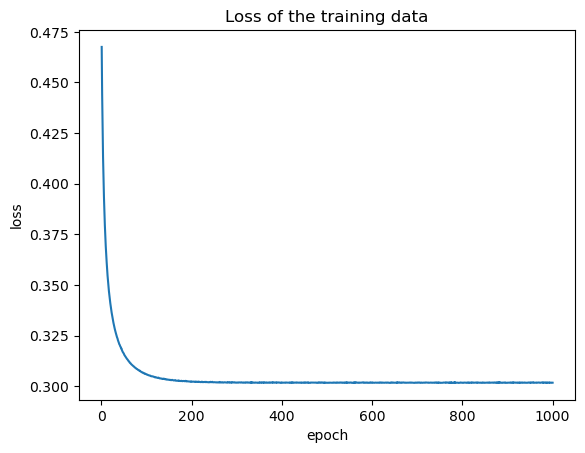

In [7]:
plt.title("Loss of the training data")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(it,loss,"-")
plt.show()

In [8]:
# Final weights and bias
print(f"Parameters at the end of the training")
for layer in model1.layers:
    weights, biases = layer.get_weights()
    print(f"  Layer   : {layer.name}")
    print(f"  Weights : {np.ravel(weights)}")
    print(f"  Bias    : {biases}")

Parameters at the end of the training
  Layer   : dense
  Weights : [ 1.2494235 -4.2733297]
  Bias    : [0.40958008]


### D.Test the model

The `evaluate` method returns the `loss` value & `metrics` values for the model in test mode.<br>
(For more info on the method, see <a href="https://keras.io/api/models/model_training_apis/#evaluate-method"><b>here</b></a>)



In [9]:
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f"Evaluation of the test set")
print(f"  Accuracy : {test_accuracy:8.4f}")
print(f"  Loss     : {test_loss:8.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8600 - loss: 0.3035
Evaluation of the test set
  Accuracy :   0.8600
  Loss     :   0.3035


### E.Predict outcomes

The `predict` method generates output predictions for the input samples.<br>
(For more info on the method, see <a href="https://keras.io/api/models/model_training_apis/#predict-method"><b>here</b></a>)


In [23]:
# Generate a data set
print(f"Generate a sample of X values ...")
X_sample, y_sample = make_moons(n_samples=100, noise=0.25, random_state=12)
print(f"  X.shape:{X_sample.shape}")
y_pred = model1.predict(X_sample,verbose=0)
y_pred = np.where(y_pred>0.5,1,0).squeeze()
print(f"  #same  :{np.sum(y_pred ==y_sample)}")

Generate a sample of X values ...
  X.shape:(100, 2)
  #same  :85


# 2.PyTorch

### Data conversion/Data Loaders
* We have 2 PyTorch data classes (to be discussed later):
  + data.Dataset : to load/create data in a class<br>
    requires: \_\_init\_\_(), \_\_len\_\_(), \_\_getitem\_\_()
  + data.DataLoader:: to load data in batches
* For the time being (conversion to PyTorch Tensor)

In [26]:
# Generate the PyTorch Tensors from the NumPy Data
# Note: default torch.float32
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)  # 2D 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)    # 2D

In [27]:
# Check Conversion from NumPy to PyTorch Tensor
START, END= 0, 2
print(f"NumPy data::")
print(f"  X_train: {X_train.shape}\n{X_train[START:END]}")
print(f"  y_train: {y_train.shape}\n{y_train[START:END]}")
print(f"\nPyTorch data::")
print(f"  X_train_tensor: {X_train_tensor.shape}\n{X_train_tensor[START:END]}")
print(f"  y_train_tensor: {y_train_tensor.shape}\n{y_train_tensor[START:END]}")

NumPy data::
  X_train: (350, 2)
[[ 1.3002999  -0.53762795]
 [-0.8817249   0.18799726]]
  y_train: (350,)
[1 0]

PyTorch data::
  X_train_tensor: torch.Size([350, 2])
tensor([[ 1.3003, -0.5376],
        [-0.8817,  0.1880]])
  y_train_tensor: torch.Size([350, 1])
tensor([[1.],
        [0.]])


### A.Setup the model

In [28]:
# Define the logistic Regression module using PyTorch
class LogisticRegressionModel2(nn.Module):

    def __init__(self, num_inputs):

        # The class inherits from the class nn.Module
        super(LogisticRegressionModel2,self).__init__()

        # Define a Single LAYER object which connects 
        #     the input with 1 single output 
        self.linear = nn.Linear(num_inputs, 1)

        # Create the ACTIVATION (object) for the Single Layer
        self.act_fn = nn.Sigmoid()

    def forward(self, x):

        # Applies the forward propagation
        z = self.linear(x)
        a = self.act_fn(z)
        return a

<font color="red"><b>Note</b></font>:
* `nn.Linear(in_features, out_features)`:
   <a href="https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html"><b>affine transformation</b></a>
* `nn.Sigmoid()`: <a href="https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid"><b>sigmoid function</b></a>
* $\ldots$

In [30]:
model2 = LogisticRegressionModel2(num_inputs=2)
print(f"  Logistic Model:{model2}")

  Logistic Model:LogisticRegressionModel2(
  (linear): Linear(in_features=2, out_features=1, bias=True)
  (act_fn): Sigmoid()
)


In [31]:
# In PyTorch, you can use either the parameters() function
# or the names_parameters() function
for name, param in model2.named_parameters():
    print(f"Name:{name:20s} -> param:{param.shape}")
    print(f"{param.data}\n")  

Name:linear.weight        -> param:torch.Size([1, 2])
tensor([[ 0.5456, -0.1317]])

Name:linear.bias          -> param:torch.Size([1])
tensor([0.0167])



### B.Compiling the model

#### B1.Loss/Objective function
* In order to find the <font color="green"><b>optimal parameters</b></font> for the weights and bias, we need
  to have an <font color="green"><b>objective function</b></font> (a.k.a Loss function)
* There are several options:
  + <a href="https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#bceloss"><b>nn.BCELoss()</b></a>:<br>
  **B**inary **C**ross **E**ntropy => inputs need to be $[0,1]$<br>
  $\begin{eqnarray}
  \mathcal{L}^{(i)} & = & -\bigg [ y_i \log(a_i) + (1-y_i)\log(1-a_i) \bigg ]
  \end{eqnarray}$
  + <a href="https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss"><b>nn.BCEWithLogitLoss()</b></a>:<br> Numerically more stable because of the combination of sigmoid and loss function at once.

In [33]:
# Creates an instance of the Binary Cross Entropy Criterion
loss_fn2 = nn.BCELoss()

#### B2.Optimization
* There are several methods to <font color="green"><b>optimize</b></font> the Loss function/Objective function.<br>
  - In this example we will use the <a href="https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html#sgd"><b>Stochastic Gradient Descent (SGD)</b></a> method<br>
    (<a href="https://docs.pytorch.org/docs/stable/optim.html"><b>torch.optim module</b></a>).
  - Later on, we will describe more powerful <font color="green"><b>optimization algorithms</b></font> (`Adam`, `AdamW`, ...).
* Useful methods:
  + step(): method update parameters
  + zero_grad() : sets the gradients of ALL optimized parameters to zero.

In [34]:
optim2 = optim.SGD(model2.parameters(), lr=0.005)

### C.Train the model
* Goal: Obtain the optimized parameters i.e. <font color="green"><b>weight matrix</b></font> and <font color="green"><b>bias</b></font>
* If the data set is **small**, then we will use **all** the training data at **once**.
* Terminology:
  - **One** complete iteration over **all** training data: <font color="green"><b>epoch</b></font>
  - For **larger** training data sets, each <font color="green"><b>epoch</b></font> is split into <font color="green"><b>batches</b></font>.<br>
    * The gradient and the parameters are <font color="blue"><b>updated</b></font> after every batch (points are selected <font color="blue"><b>randomly</b></font>):<br>
      <font color="green"><b>stochastic gradient descent (SGD)</b></font>
    * The batch size is a <font color="green"><b>hyperparameter</b></font>. 

In [35]:
def train_model(X_train_tensor, y_train_tensor, model, loss_fn, 
                optim, num_epochs=100000 , delta_print=10000):
    """"
    Function which trains the model
    """
    
    # Set model to train mode
    # Strictly not necessary for our case 
    model.train()

    # Loop over the epochs
    for epoch in range(num_epochs):

        # PART A: FORWARD PROPAGATION ( => )
        # Step 1: Generate the output (activation of the linear layer)
        output = model(X_train_tensor)

        # Step 2: Use the activation of the last layer & the labels
        #         to calculate the loss.
        loss = loss_fn(output, y_train_tensor)

        # Step B: BACK PROPAGATION ( <= )
        # Step 3: Calculate the gradients of the parameters
        optim.zero_grad()   # Init. the gradients to ZERO!!
        loss.backward()     # Calc. grad. of param.

        # Step 4: Adjust the parameters 
        optim.step()

        if (epoch+1)%delta_print == 0 or epoch==0:
           print(f"  Epoch {epoch+1}/{num_epochs}  Loss:{loss.item():.6f}")
                
    return loss.item()       

In [42]:
# Train the model
final_loss2 = train_model(X_train_tensor, y_train_tensor, model2, loss_fn2, optim2)
print(f"Loss in the last step:{final_loss2:.6f}")

  Epoch 1/100000  Loss:0.301552
  Epoch 10000/100000  Loss:0.301552
  Epoch 20000/100000  Loss:0.301552
  Epoch 30000/100000  Loss:0.301552
  Epoch 40000/100000  Loss:0.301552
  Epoch 50000/100000  Loss:0.301552
  Epoch 60000/100000  Loss:0.301552
  Epoch 70000/100000  Loss:0.301552
  Epoch 80000/100000  Loss:0.301552
  Epoch 90000/100000  Loss:0.301552
  Epoch 100000/100000  Loss:0.301552
Loss in the last step:0.301552


In [37]:
# HOW TO Check the final parameters
#   Method 1:
print(f"METHOD 1::")
print(f"Weights::\n{model2.linear.weight}\n")
print(f"Bias   ::\n{model2.linear.bias}")

print(f"\nMETHOD 2::")
for name, param in model2.state_dict().items():
    print(f"{name} -> {param.shape}")
    print(f"  {param.data}")

METHOD 1::
Weights::
Parameter containing:
tensor([[ 1.2507, -4.2648]], requires_grad=True)

Bias   ::
Parameter containing:
tensor([0.4057], requires_grad=True)

METHOD 2::
linear.weight -> torch.Size([1, 2])
  tensor([[ 1.2507, -4.2648]])
linear.bias -> torch.Size([1])
  tensor([0.4057])


#### Save/load the model to & from disk
* To <font color="green"><b>save</b></font> an object to disk, use <a href="https://docs.pytorch.org/docs/stable/generated/torch.save.html#torch-save"><b>torch.save()</b></a>
* To <font color="green"><b>load</b></font> an object from disk, use <a href="https://docs.pytorch.org/docs/stable/generated/torch.load.html#torch-load"><b>torch.load()</b></a>

In [38]:
filename='linreg2.pth'
torch.save(model2.state_dict(), filename)

newmodel = LogisticRegressionModel2(num_inputs=2)
state = torch.load(filename, map_location="cpu")
newmodel.load_state_dict(state)

<All keys matched successfully>

<font color="red"><b>Important Notes:</b><font>
* The line `output = model(X_train_tensor)` calls the **forward** method.<br>
  How does this work?
  - `model(X_train_tensor)` invokes the `__call__` method<br> of the base class i.e. $\texttt{nn.Module}$
  - The `__call__` method does 2 things:
    + Handles hooks (e.g. for debugging)
    + Calls the `forward` method.
* `optim.zero_grad()`: forces to set the gradient vector to zero (accumulation)

### D.Test the model

In [40]:
def test_model(X_tensor, y_tensor, model):

    model.eval()
    with torch.no_grad():
        res_tensor = model(X_tensor)
        ypred_tensor =(res_tensor>0.5).float()
    return ypred_tensor    

def get_accuracy(y_pred, y):
    num_ok = float((y_pred == y).sum())
    return (num_ok / y_pred.shape[0]) * 100.0

In [41]:
y_trainpred_tensor = test_model(X_train_tensor, y_train_tensor, model2)
acc_train = get_accuracy(y_trainpred_tensor, y_train_tensor)
print(f"Accuracy train:{acc_train:8.4f}")

y_testpred_tensor = test_model(X_test_tensor, y_test_tensor, model2)
acc_test = get_accuracy(y_testpred_tensor, y_test_tensor)
print(f"Accuracy test:{acc_test:8.4f}")

Accuracy train: 84.2857
Accuracy test: 86.0000


### Alternative implementation within PyTorch (numerical stability)

In the previous section, we implemented the 
* <font color="green"><b>activation function</b></font> $a_i$, i.e.<br>
  $\begin{eqnarray}
     a_i & = & \sigma(z_i)\\
         & = & \frac{1}{1+e^{-z_i}} \\
  \end{eqnarray}$
* loss function $\mathcal{L}^{(i)}$, i.e.<br>
  $\begin{eqnarray}
       \mathcal{L}^{(i)} & = & - \bigg [ y_i \log(a_i) + (1-y_i)\log(1-a_i) \bigg ] 
  \end{eqnarray}$<br>
separately.

To render the <font color="green"><b>optimization numerically more stable</b></font> the <font color="green"><b>activation and the loss function</b></font> can be combined into **one** function.<br>
The corresponding loss function bears the name <a href="https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss"><b>BCEWithLogitsLoss</b></a>
and is given by:

$\begin{eqnarray}
  \mathcal{L}^{(i)} & = & -\bigg [ y_i \log(a_i) + (1-y_i)\log(1-a_i) \bigg ]\\ 
                    & = & z_i(1-y_i) + \log(1+e^{-z_i}) \\
\end{eqnarray}$

#### **Exercise 1**:
* Implement the `class LogisticRegressionModelEx(nn.Module)`

In [ ]:
# Define the logistic Regression module using PyTorch 
class LogisticRegressionModelEx(nn.Module):

    def __init__(self, num_inputs):

        # The class inherits from the class nn.Module
        super(LogisticRegressionModelEx,self).__init__()

        # <--- YOUR CODE

    def forward(self, x):

        # Applies the forward propagation
        # <--- YOUR CODE

In [ ]:
# %load solutions/kerastorch/sol_ex1.py

Check the model <font color="blue"><b>(ante optimization)</b></font>

In [ ]:
modelEx = LogisticRegressionModelEx(num_inputs=2)
print(f"  Logistic Model:{modelEx}")

for name, param in modelEx.named_parameters():
    print(f"Name:{name:20s} -> param:{param.shape}")
    print(f"{param.data}\n")

#### **Exercise 2**:
* Implement the `loss_fnEx` using BCEWithLogitsLoss

In [ ]:
# Here comes your code to define the BCEWithLogitsLoss
loss_fnEx = # <--- Here comes your code

In [ ]:
# %load solutions/kerastorch/sol_ex2.py

In [ ]:
optimEx = optim.SGD(modelEx.parameters(), lr=0.005)
final_lossEx = train_model(X_train_tensor, y_train_tensor, modelEx, loss_fnEx, optimEx)
print(f"Loss in the last step:{final_lossEx:.6f}")

Check the model <font color="blue"><b>(post optimization)</b></font>

In [ ]:
for name, param in modelEx.named_parameters():
    print(f"Name:{name:20s} -> param:{param.shape}")
    print(f"{param.data}\n")